In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from collections import defaultdict, Counter
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/684folder/processed_real_data_large.csv'

Mounted at /content/drive


## Data Preparation

In [4]:
# data = pd.read_csv("synthetic_reviews.csv")
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,Age,Review Text,Rating,Recommended IND,Positive Feedback Count
0,0,37,a great little dress that can be dressed up or...,5,1,0
1,1,44,i found this in store last weekend and thought...,5,1,8
2,2,32,i bought one of these as a gift for a friend a...,5,1,0
3,3,54,"i love this tunic, the detail the weight, the ...",4,1,2
4,4,58,i got this in the color listed as pink. it is ...,5,1,3


Distribution of recommended IND, ratings and age.

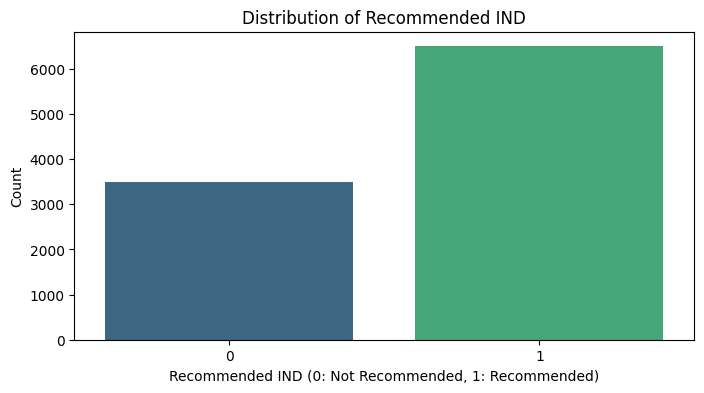

In [5]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x="Recommended IND", hue="Recommended IND", palette="viridis", dodge=False, legend=False)
plt.title("Distribution of Recommended IND")
plt.xlabel("Recommended IND (0: Not Recommended, 1: Recommended)")
plt.ylabel("Count")
plt.show()

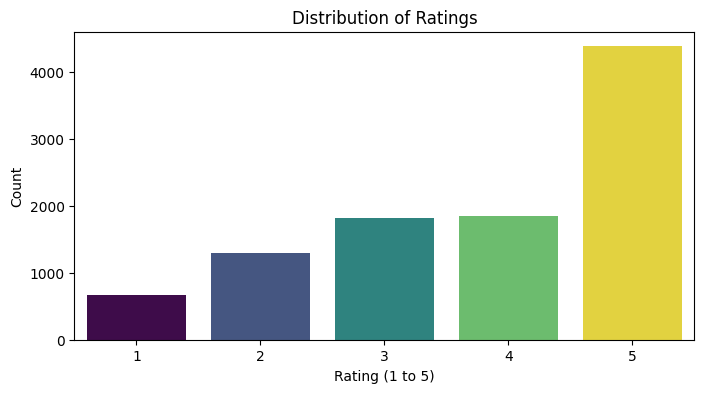

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x="Rating", hue="Rating", palette="viridis", dodge=False, legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()

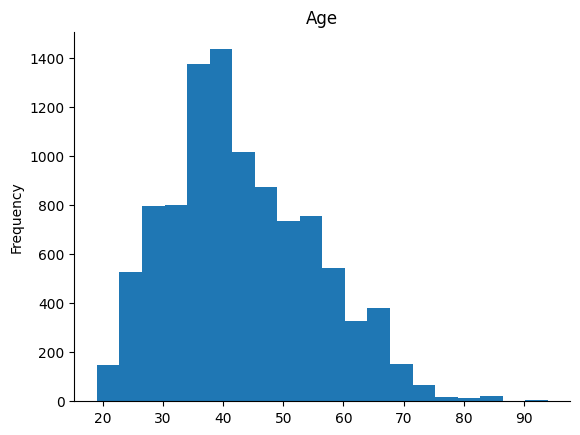

In [7]:
data['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

Prepare input-review texts and output-recommended IND for model to train.

In [8]:
review_texts = data["Review Text"].values
labels = data["Recommended IND"].values
data[["Review Text", "Recommended IND"]].head()

,Review Text,Recommended IND
0,a great little dress that can be dressed up or...,1
1,i found this in store last weekend and thought...,1
2,i bought one of these as a gift for a friend a...,1
3,"i love this tunic, the detail the weight, the ...",1
4,i got this in the color listed as pink. it is ...,1


In [9]:
x_train, x_test, y_train, y_test = train_test_split(review_texts, labels, test_size=0.2, random_state=19)
print(f"x_train shape: {len(x_train)}")
print(f"x_test shape: {len(x_test)}")
print(f"y_train shape: {len(y_train)}")
print(f"y_test shape: {len(y_test)}")

x_train shape: 8000
x_test shape: 2000
y_train shape: 8000
y_test shape: 2000


## Construct Bigram Naive Bayes Classifier Model

In [10]:
class BigramNaiveBayesClassifier:
    def __init__(self):
        self.prior_probs = {}  # P(C)
        self.bigram_probs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 1e-6)))  # P(w2|w1, C)
        self.class_counts = Counter()  # Count number of samples in each class

    def train(self, texts, labels):
        bigram_counts = defaultdict(lambda: defaultdict(Counter)) # nested dictionary to record probability of two words appearing one after the other
        total_samples = len(labels)

        for text, label in zip(texts, labels):
            tokens = nltk.word_tokenize(text.lower())
            bigrams = list(nltk.bigrams(tokens)) # Combine two words toghther
            self.class_counts[label] += 1
            for w1, w2 in bigrams:
                bigram_counts[label][w1][w2] += 1

        # For P(C)
        self.prior_probs = {label: count / total_samples for label, count in self.class_counts.items()}

        # For P(w2|w1, C)
        for label, w1_dict in bigram_counts.items():
            for w1, w2_counts in w1_dict.items():
                total_count = sum(w2_counts.values())
                for w2, count in w2_counts.items():
                    self.bigram_probs[label][w1][w2] = count / total_count

    def predict(self, text):
        tokens = nltk.word_tokenize(text.lower())
        bigrams = list(nltk.bigrams(tokens)) # Combine two words toghther

        class_prob = {}
        # calculate prob for recommended and not recommended respectively
        for label in [0,1]:
            score = math.log(self.prior_probs[label])
            for w1, w2 in bigrams:
                score += math.log(self.bigram_probs[label][w1][w2] + 1e-6) # 0 would have error
            class_prob[label] = score

        # Find the classifier with highest probability
        return max(class_prob, key=class_prob.get)

## Training and Testing

In [11]:
bayerClassifier = BigramNaiveBayesClassifier()
bayerClassifier.train(x_train, y_train) # Calculate some P(C) and P(w2|w1, C)

In [12]:
predictions = []
for text in x_test:
    prediction = bayerClassifier.predict(text)
    predictions.append(prediction)

# calculate accuracy, precision, recall and f1-score
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average="binary")
recall = recall_score(y_test, predictions, average="binary")
f1 = f1_score(y_test, predictions, average="binary")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7985
Precision: 0.7976
Recall: 0.9218
F1 Score: 0.8552


In [13]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)
tn, fp, fn, tp = conf_matrix.ravel()
print(f"Recommended - Predicted Correctly: {tp}/{tp+fn}")
print(f"Not Recommended - Predicted Correctly: {tn}/{tn+fp}")

Confusion Matrix:
[[ 407  302]
 [ 101 1190]]
Recommended - Predicted Correctly: 1190/1291
Not Recommended - Predicted Correctly: 407/709


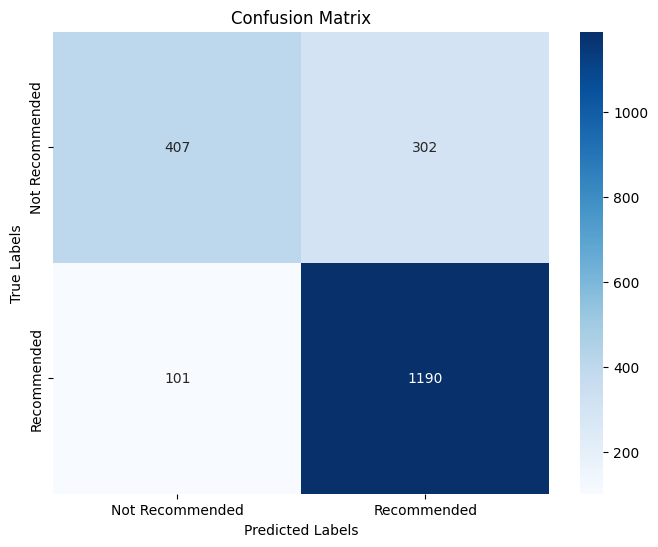

In [14]:
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Recommended", "Recommended"], yticklabels=["Not Recommended", "Recommended"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Recommended", "Recommended"],
            yticklabels=["Not Recommended", "Recommended"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [15]:
test_reviews = [
    # Recommended (Positive sentiment)
    "This product is amazing!",
    "I love this item, it's perfect for me.",
    "Absolutely fantastic quality, highly recommend.",
    "Good value for the price, exceeded my expectations.",
    "Pretty good, I’m satisfied with my purchase.",
    "Decent quality, works as advertised.",
    "It's okay, does the job but nothing special.",
    "Overall a good purchase, I would recommend it.",
    "The features are nice, better than I expected.",
    "I’m happy with this, great choice for the price.",

    # Not Recommended (Negative sentiment)
    "Terrible product, broke after one use.",
    "Awful quality, not worth the money.",
    "I’m disappointed, completely useless.",
    "Not great, feels cheap and flimsy.",
    "Would not recommend, didn’t meet my expectations.",
    "The quality is poor, I expected more.",
    "It’s acceptable but barely usable.",
    "Nothing special, very average at best.",
    "Doesn’t work as expected, quite frustrating.",
    "I regret buying this, waste of money.",
]
print("Predictions for Test Reviews:")
for idx, review in enumerate(test_reviews):
    prediction = bayerClassifier.predict(review)
    print(f"\nReview {idx+1}: {review}")
    print(f"Predicted class (0: Not Recommended, 1: Recommended): {prediction}")

Predictions for Test Reviews:

Review 1: This product is amazing!
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 2: I love this item, it's perfect for me.
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 3: Absolutely fantastic quality, highly recommend.
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 4: Good value for the price, exceeded my expectations.
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 5: Pretty good, I’m satisfied with my purchase.
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 6: Decent quality, works as advertised.
Predicted class (0: Not Recommended, 1: Recommended): 0

Review 7: It's okay, does the job but nothing special.
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 8: Overall a good purchase, I would recommend it.
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 9: The features are nice, better than I expected.
Predicted class (0: Not Recommended, 1

## Real Data Testcases

In [16]:
test_file_path = '/content/drive/MyDrive/684folder//20randomcases.csv'
real_test_data = pd.read_csv(test_file_path)
real_test_data_sorted = real_test_data.sort_values(by="Recommended IND", ascending=False)
real_test_data_sorted.head()

,Unnamed: 0,Age,Review Text,Rating,Recommended IND,Positive Feedback Count
0,0,42,always attracted to wool for its warmth and br...,5,1,15
7,7,55,unusual design and striking color make this th...,5,1,1
16,16,31,expected them to fit somewhat loose but actual...,4,1,3
14,14,42,love the cute print and texture of fabric. per...,4,1,0
12,12,48,i got this in the green blue pink motif and i ...,5,1,3


In [17]:
print("\nPredictions for Real Test Data:")
id = 0
for idx, row in real_test_data_sorted.iterrows():
    review_text = row["Review Text"]
    actual_label = row["Recommended IND"]

    predicted_label = bayerClassifier.predict(review_text)

    print(f"\nReview {id + 1}: {review_text}")
    print(f"Actual Label (0: Not Recommended, 1: Recommended): {actual_label}")
    print(f"Predicted Label (0: Not Recommended, 1: Recommended): {predicted_label}")
    id += 1


Predictions for Real Test Data:

Review 1: always attracted to wool for its warmth and breathability. this jacket has great style that can be casual or dressed up some. it is slightly more boxy then expected which i think lends to the casual look. find myself wearing it a lot.
Actual Label (0: Not Recommended, 1: Recommended): 1
Predicted Label (0: Not Recommended, 1: Recommended): 1

Review 2: unusual design and striking color make this the perfect dress this winter season. the fit is flattering and the design makes it perfect for work or play.
Actual Label (0: Not Recommended, 1: Recommended): 1
Predicted Label (0: Not Recommended, 1: Recommended): 1

Review 3: expected them to fit somewhat loose but actually tight for a boyfriend fit. like a slightly relaxed skinny with a really low crotch. stretches everywhere when sitting and walking except the waistband. the distressing and fraying holes in good placement. wish there was some on the back of the leg but i have yet to find a pair 